# Dataset: data3D.csv

* Read Dataset
* Pre-process data
* Use K-Means to cluster 3D points

In [1]:
import pyspark
from pyspark import SparkContext

sc = SparkContext(master='local', appName = '3D_points')

In [2]:
import findspark
findspark.init()
import pyspark
findspark.find()

'/Users/vunguyen/server/spark-2.4.6-bin-hadoop2.7'

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
'''
conf= pyspark.SparkConf().setAppName('tets_app').setMaster('local')
sc=pyspark.SparkContext(conf=conf)
sc
'''

#sc= SparkContext()
spark = (SparkSession
         .builder
         .appName('3D_points')
         .getOrCreate())
spark

In [4]:
data = spark.read.csv('File/data3D.csv', header = True, inferSchema=True)

In [5]:
data.show(3)

+------+-----------------+------------------+------------------+
|    id|                x|                 y|                 z|
+------+-----------------+------------------+------------------+
|point0|5.647627534046943|-6.356222340123802|-7.240816026826695|
|point1|4.414367138680041|-10.32624175635328| 8.963324308916228|
|point2|5.005396944639823|-9.301070062115645| 10.35473056351597|
+------+-----------------+------------------+------------------+
only showing top 3 rows



In [6]:
data = data.select(['x','y','z'])

In [7]:
data.show(3)

+-----------------+------------------+------------------+
|                x|                 y|                 z|
+-----------------+------------------+------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|
|4.414367138680041|-10.32624175635328| 8.963324308916228|
|5.005396944639823|-9.301070062115645| 10.35473056351597|
+-----------------+------------------+------------------+
only showing top 3 rows



In [8]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [9]:
data.columns

['x', 'y', 'z']

In [10]:
vec_assembler = VectorAssembler(
            inputCols=data.columns,
            outputCol='features')

In [11]:
final_data = vec_assembler.transform(data)

Dont need to scale data, because the numbers is not high, the distance between them is normal

In [12]:
from pyspark.ml.clustering import KMeans

In [13]:
k_list = []
wssse_list = []
for k in range(2,11):
#     Nếu bài toán k scale thì đưa feature vào, còn nếu đã scaled thì lấy col đã scale vào
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(final_data)
    wssse = model.computeCost(final_data)
    k_list.append(k)
    wssse_list.append(wssse)
    print('k =',k,'WSSE = ' + str(wssse))

k = 2 WSSE = 45986645.26272916
k = 3 WSSE = 10318450.986694533
k = 4 WSSE = 7962772.952404431
k = 5 WSSE = 2988261.404456032
k = 6 WSSE = 2854999.9464747766
k = 7 WSSE = 2727630.343215306
k = 8 WSSE = 2603723.3229706665
k = 9 WSSE = 2476246.8957771985
k = 10 WSSE = 2394382.9506517565


Select k=5 because k=5 where the WSSE decrease strongly and after that it fell steadily

In [14]:
kmeans = KMeans(featuresCol='features', k=5)
model = kmeans.fit(final_data)
    
wssse = model.computeCost(final_data)
print('WSSE = ' + str(wssse))

WSSE = 2988261.404456032


In [15]:
centers = model.clusterCenters()
print('Cluster Center:')
for center in centers:
    print(center)

Cluster Center:
[-2.51171188  9.01595695  4.63712426]
[ 1.96549346 -6.88119669 -6.87975076]
[ 4.16341491 -9.58797827  9.39987937]
[ 6.65778113 -5.75041752 -6.36930371]
[-8.84025639  7.32373332  2.02350234]


In [16]:
predictions = model.transform(final_data)

In [17]:
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         3|
|         2|
|         2|
|         2|
|         4|
+----------+
only showing top 5 rows



In [18]:
predictions.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1|200041|
|         3|199959|
|         4|199981|
|         2|200000|
|         0|200019|
+----------+------+



They have equal size for each cluster

In [19]:
data_result = predictions.select('prediction')
data_result

DataFrame[prediction: int]

In [20]:
data_result.columns

['prediction']

In [21]:
final_data.show(3)

+-----------------+------------------+------------------+--------------------+
|                x|                 y|                 z|            features|
+-----------------+------------------+------------------+--------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|[5.64762753404694...|
|4.414367138680041|-10.32624175635328| 8.963324308916228|[4.41436713868004...|
|5.005396944639823|-9.301070062115645| 10.35473056351597|[5.00539694463982...|
+-----------------+------------------+------------------+--------------------+
only showing top 3 rows



In [22]:
temp = final_data.select('features').rdd.map(lambda x: x[0].toArray().tolist()).toDF()

In [23]:
temp.show(3)

+-----------------+------------------+------------------+
|               _1|                _2|                _3|
+-----------------+------------------+------------------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|
|4.414367138680041|-10.32624175635328| 8.963324308916228|
|5.005396944639823|-9.301070062115645| 10.35473056351597|
+-----------------+------------------+------------------+
only showing top 3 rows



In [24]:
import pyspark.sql.functions as f

In [26]:
temp = temp.withColumn('row_index', f.monotonically_increasing_id())
data_result = data_result.withColumn('row_index', f.monotonically_increasing_id())
temp = temp.join(data_result, on=['row_index']).sort('row_index').drop('row_index')

In [27]:
temp.show()

+-------------------+-------------------+-------------------+----------+
|                 _1|                 _2|                 _3|prediction|
+-------------------+-------------------+-------------------+----------+
|  5.647627534046943| -6.356222340123802| -7.240816026826695|         3|
|  4.414367138680041| -10.32624175635328|  8.963324308916228|         2|
|  5.005396944639823| -9.301070062115645|  10.35473056351597|         2|
|  4.120163380083817| -7.602476887414266| 11.899997733558848|         2|
|  -9.90345298323414|  6.018967450867092| 2.0499450056095667|         4|
|-3.1594393958474907|  8.573317231663315|  2.358313545308847|         0|
| -7.397441928137873|  8.045395595903233| 1.7854606646015299|         4|
|-0.9693510271500931|  7.862982927569075| 3.2409227574252446|         0|
| 0.8429846570527002| -7.512538594618869| -7.011648822392197|         1|
|  5.790224308267301|-12.205503891046252|  8.483613639072914|         2|
| -9.446537710309725|  8.119076412296552|-0.4233730

In [30]:
from pyspark.sql.functions import col

temp=temp.select(col('_1').alias('x_scale'), 
                 col('_2').alias('y_scale'),
                 col('_3').alias('z_scale'), 
                'prediction')

In [31]:
df = temp.toPandas()

In [32]:
df.head(3)

,x_scale,y_scale,z_scale,prediction
0,5.647628,-6.356222,-7.240816,3
1,4.414367,-10.326242,8.963324,2
2,5.005397,-9.301070,10.354731,2


In [34]:
import pandas as pd

centers_df = pd.DataFrame(centers)
centers_df.head()

,0,1,2
0,-2.511712,9.015957,4.637124
1,1.965493,-6.881197,-6.879751
2,4.163415,-9.587978,9.399879
3,6.657781,-5.750418,-6.369304
4,-8.840256,7.323733,2.023502


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

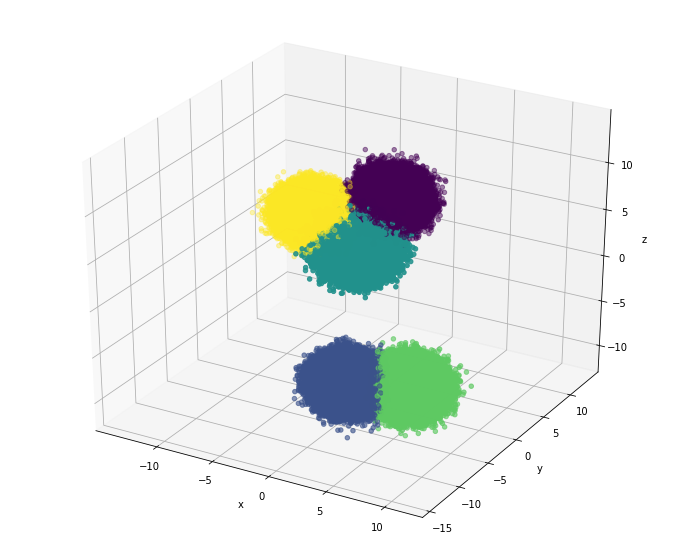

In [36]:
TD = plt.figure(figsize=(12,10)).gca(projection='3d')
TD.scatter(df.x_scale, df.y_scale, df.z_scale,
                c = df.prediction)
TD.set_xlabel('x')
TD.set_ylabel('y')
TD.set_zlabel('z')

plt.show()

# Combine result

In [37]:
final_data = final_data.withColumn('row_index', f.monotonically_increasing_id())
temp = temp.withColumn('row_index', f.monotonically_increasing_id())
final_data = final_data.join(temp, on=['row_index']).sort('row_index').drop('row_index')

In [38]:
final_data.show(3, False)

+-----------------+------------------+------------------+---------------------------------------------------------+-----------------+------------------+------------------+----------+
|x                |y                 |z                 |features                                                 |x_scale          |y_scale           |z_scale           |prediction|
+-----------------+------------------+------------------+---------------------------------------------------------+-----------------+------------------+------------------+----------+
|5.647627534046943|-6.356222340123802|-7.240816026826695|[5.647627534046943,-6.356222340123802,-7.240816026826695]|5.647627534046943|-6.356222340123802|-7.240816026826695|3         |
|4.414367138680041|-10.32624175635328|8.963324308916228 |[4.414367138680041,-10.32624175635328,8.963324308916228] |4.414367138680041|-10.32624175635328|8.963324308916228 |2         |
|5.005396944639823|-9.301070062115645|10.35473056351597 |[5.005396944639823,-9.301070